# Data Import and EDA

In [25]:
import pandas as pd

# Load energy scores dataset
labeled_df = pd.read_csv("data/shr_v_temp_phase.csv")

# Load daytime naps
daytime_nap = pd.read_csv("data/daytime_naps.csv")

# Load nighttime sleep sessions
nighttime_sleep = pd.read_csv("data/nighttime_sleep.csv")
nighttime_sleep_features_df = nighttime_sleep[
    [
        "local_end_time_date",
        "local_start_time_hour",
        "deep_sleep_duration",
        "total_rem_duration",
        "sleep_cycle"
    ]
].copy()

# Merge the nighttime sleep with the labeled_df
labeled_df = pd.merge(
    labeled_df,
    nighttime_sleep_features_df,
    how='left',
    left_on='day_time',
    right_on='local_end_time_date'
)

# Convert day_time and nap start dates to datetime
labeled_df['day_time'] = pd.to_datetime(labeled_df['day_time'])
daytime_nap['local_start_time_date'] = pd.to_datetime(
    daytime_nap['local_start_time_date'])

# Create a nap label (outcome variable): 1 if nap occurred on that date, 0 otherwise
nap_dates = set(daytime_nap['local_start_time_date'])
labeled_df['nap_occurred'] = labeled_df['day_time'].isin(nap_dates).astype(int)


labeled_df.head(10)

,day_time,shr_value,shrv_value,sleep_duration,temperature,phase,local_end_time_date,local_start_time_hour,deep_sleep_duration,total_rem_duration,sleep_cycle,nap_occurred
0,2024-12-17,64.03,43.16,22187142,NaN,luteal,2024-12-17,3,37.00,50.00,2.00,0
1,2024-12-18,69.21,41.22,23627142,36.58,luteal,2024-12-18,22,80.00,113.00,5.00,0
2,2024-12-19,69.41,37.72,24017142,36.34,luteal,2024-12-19,22,75.00,98.00,4.00,1
3,2024-12-20,70.99,41.28,24510000,36.46,luteal,2024-12-20,23,62.00,108.00,5.00,0
4,2024-12-21,70.79,34.16,24904285,36.53,luteal,2024-12-21,23,80.00,98.00,4.00,1
5,2024-12-22,70.81,35.68,24810000,36.59,luteal,2024-12-22,22,96.00,142.00,5.00,1
6,2024-12-23,68.03,38.05,25804285,36.71,luteal,2024-12-23,23,51.00,83.00,4.00,1
7,2024-12-24,66.30,38.92,27090000,36.61,luteal,2024-12-24,23,60.00,102.00,7.00,0
8,2024-12-25,71.03,38.57,27231428,36.57,luteal,2024-12-25,23,83.00,119.00,4.00,0
9,2024-12-26,69.85,38.27,26365714,36.53,luteal,2024-12-26,2,75.00,55.00,3.00,0


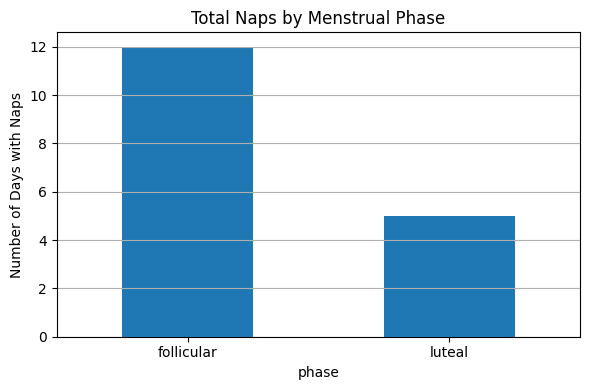

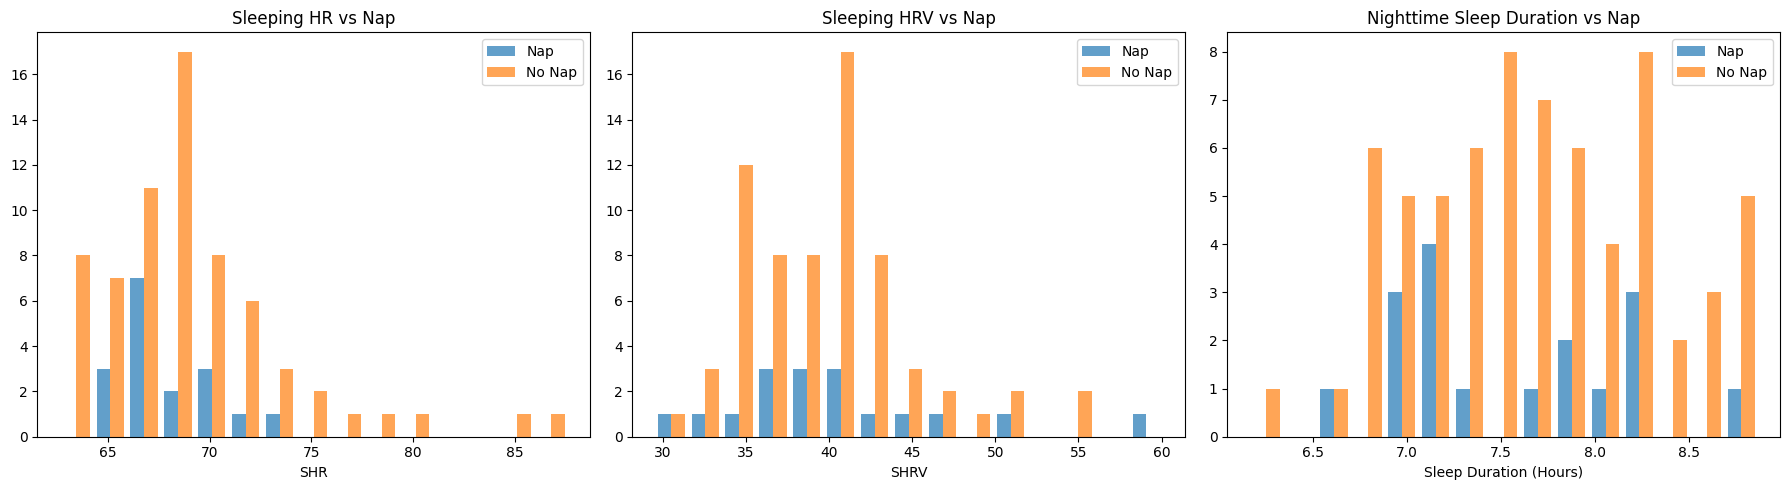

In [26]:
import matplotlib.pyplot as plt

# Convert 'phase' to category for plotting
labeled_df['phase'] = labeled_df['phase'].astype('category')

# EDA 1: Nap frequency by menstrual phase
phase_nap_counts = labeled_df.groupby('phase')['nap_occurred'].sum()

plt.figure(figsize=(6, 4))
phase_nap_counts.plot(kind='bar')
plt.title("Total Naps by Menstrual Phase")
plt.ylabel("Number of Days with Naps")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# EDA 2: Distribution of sleep metrics vs nap
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].hist([labeled_df[labeled_df['nap_occurred'] == 1]['shr_value'],
             labeled_df[labeled_df['nap_occurred'] == 0]['shr_value']], 
            bins=15, label=['Nap', 'No Nap'], alpha=0.7)
axs[0].set_title("Sleeping HR vs Nap")
axs[0].set_xlabel("SHR")
axs[0].legend()

axs[1].hist([labeled_df[labeled_df['nap_occurred'] == 1]['shrv_value'],
             labeled_df[labeled_df['nap_occurred'] == 0]['shrv_value']], 
            bins=15, label=['Nap', 'No Nap'], alpha=0.7)
axs[1].set_title("Sleeping HRV vs Nap")
axs[1].set_xlabel("SHRV")
axs[1].legend()

axs[2].hist([labeled_df[labeled_df['nap_occurred'] == 1]['sleep_duration'] / 3600000,
             labeled_df[labeled_df['nap_occurred'] == 0]['sleep_duration'] / 3600000], 
            bins=15, label=['Nap', 'No Nap'], alpha=0.7)
axs[2].set_title("Nighttime Sleep Duration vs Nap")
axs[2].set_xlabel("Sleep Duration (Hours)")
axs[2].legend()

plt.tight_layout()
plt.show()


# Feature Engineering

In [27]:
import numpy as np

# Start with a copy of the labeled dataset
fe_df = labeled_df.copy()
fe_df = fe_df.sort_values('day_time').reset_index(drop=True)

# Feature 1: Days since last nap
fe_df['days_since_nap'] = np.nan
last_nap_day = None
for i, row in fe_df.iterrows():
    if row['nap_occurred'] == 1:
        fe_df.at[i, 'days_since_nap'] = 0
        last_nap_day = i
    elif last_nap_day is not None:
        fe_df.at[i, 'days_since_nap'] = i - last_nap_day

# Fill missing with max+1
fe_df['days_since_nap'] = fe_df['days_since_nap'].fillna(fe_df['days_since_nap'].max() + 1)

fe_df.head()

,day_time,shr_value,shrv_value,sleep_duration,temperature,phase,local_end_time_date,local_start_time_hour,deep_sleep_duration,total_rem_duration,sleep_cycle,nap_occurred,days_since_nap
0,2024-12-17,64.03,43.16,22187142,NaN,luteal,2024-12-17,3,37.00,50.00,2.00,0,18.00
1,2024-12-18,69.21,41.22,23627142,36.58,luteal,2024-12-18,22,80.00,113.00,5.00,0,18.00
2,2024-12-19,69.41,37.72,24017142,36.34,luteal,2024-12-19,22,75.00,98.00,4.00,1,0.00
3,2024-12-20,70.99,41.28,24510000,36.46,luteal,2024-12-20,23,62.00,108.00,5.00,0,1.00
4,2024-12-21,70.79,34.16,24904285,36.53,luteal,2024-12-21,23,80.00,98.00,4.00,1,0.00


# Problem Breakdown

# LazyPredict for Classification

In [28]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler

# Define features (independent variables) and target (nap or not)
fe_df = fe_df.dropna()
FEATURES = [
    "shr_value",
    "shrv_value",
    "sleep_duration",
    "temperature",
    "local_start_time_hour",
    "deep_sleep_duration",
    "total_rem_duration",
    "sleep_cycle",
    "days_since_nap",
]
X = fe_df[FEATURES].copy()

# Convert categorical features to numerical
y = fe_df["nap_occurred"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Run LazyClassifier
clf = LazyClassifier(ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Show results
models

100%|██████████| 30/30 [00:00<00:00, 40.87it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.06
GaussianNB,1.00,1.00,1.00,1.00,0.01
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.01
BaggingClassifier,1.00,1.00,1.00,1.00,0.08
ExtraTreeClassifier,1.00,1.00,1.00,1.00,0.02
RandomForestClassifier,1.00,1.00,1.00,1.00,0.11
PassiveAggressiveClassifier,0.96,0.90,0.90,0.96,0.01
LinearSVC,0.92,0.87,0.87,0.92,0.01
Perceptron,0.83,0.75,0.75,0.83,0.01


# Further Analysis: LogisticRegression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score


# We already scaled the data above so we don't need to do it again
model = LogisticRegression()

# Fit the pipeline
fitted_model = model.fit(X_train, y_train)


# Model evaluation
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # Print accuracy score
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Print ROC AUC score (??? Needs investigation)
    print("ROC AUC:", roc_auc_score(y_test, y_pred))


# Evaluate the model
evaluate_model(fitted_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.40      0.57         5

    accuracy                           0.88        24
   macro avg       0.93      0.70      0.75        24
weighted avg       0.89      0.88      0.85        24

[[19  0]
 [ 3  2]]
Accuracy: 0.875
ROC AUC: 0.7


# SHAP Analysis

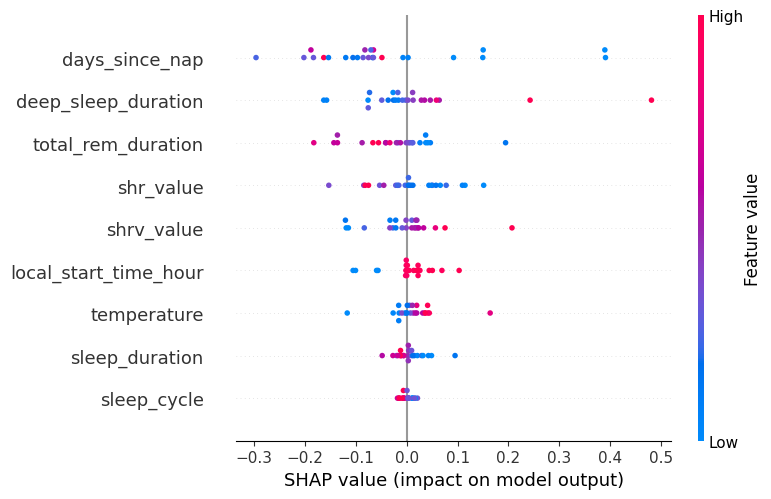

In [30]:
import shap

# Use SHAP's LinearExplainer for logistic regression
explainer = shap.Explainer(model.predict, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=FEATURES)